In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

#read in data
data = pd.read_csv('/kaggle/input/vancouver-cars-cleaned/cars_cleaned.csv')

#### missing values #####
data.dropna(inplace=True)#there are only a few dozen missing values so drop those rows

#cleaning
data = data[data.odometer<1e6] #drop rows where the odometer is very high
data = data[data.price<1e5] #drop rows where the price is very high

data.head()

,condition,drive,fuel,location,odometer,paint color,price,sale type,title status,transmission,...,year,age,make_,model,pos_words,neg_words,low_text,model0,model1,model2
0,good,4wd,gas,vancouver,281000,white,5500,owner,rebuilt,automatic,...,2007,14,bmw,x3,False,False,False,x3,None,None
1,unknown,fwd,gas,vancouver,140000,unknown,600,owner,clean,automatic,...,1984,37,honda,accord,False,False,False,accord,None,None
2,excellent,rwd,diesel,vancouver,110000,white,67000,owner,clean,automatic,...,2008,13,gmc,c7500,False,False,False,c7500,None,None
3,unknown,fwd,gas,vancouver,243000,unknown,4000,owner,clean,automatic,...,2003,18,acura,rsx,True,False,False,rsx,None,None
4,salvage,fwd,gas,vancouver,225000,black,1500,owner,salvage,automatic,...,2005,16,acura,rsx,False,False,False,rsx,None,None


GridSearchCV fitting...
{'num_leaves': 50} -> 2669.7123251740877
{'num_leaves': 100} -> 2512.358073781562
{'num_leaves': 200} -> 2470.3686642084235
{'num_leaves': 400} -> 2483.760793185689
{'num_leaves': 800} -> 2526.450789603903


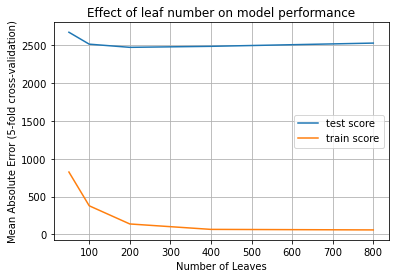

In [3]:
#### create training and validation data ####
X = data.copy()
y = X.pop('price')

#locating categorical and numeric columns
cat_cols = X.columns[X.dtypes.values=='O']
numeric_cols = [col for col in X.columns if col not in cat_cols] #the rest are numeric

for col in cat_cols:
    X[col] = X[col].astype('category')

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)

model = LGBMRegressor(num_leaves = 200, 
                      min_child_samples=10,
                      random_state = 0, 
                      n_estimators = 1000, 
                      metric='l1')

params = {
    'num_leaves': [50, 100, 200, 400, 800],
         }

searchCV = GridSearchCV(model, scoring='neg_mean_absolute_error', cv=5, param_grid=params, return_train_score=True)
print('GridSearchCV fitting...')
searchCV.fit(X_train, y_train)
scores = -1*searchCV.cv_results_['mean_test_score']
train_scores = -1*searchCV.cv_results_['mean_train_score']
params_out = searchCV.cv_results_['params']
for i in range(0, len(scores)):
  print(params_out[i], '->', scores[i])

x = params['num_leaves']
plt.plot(x, scores, label = 'test score')
plt.plot(x, train_scores, label = 'train score')
plt.title('Effect of leaf number on model performance')
plt.xlabel('Number of Leaves')
plt.ylabel('Mean Absolute Error (5-fold cross-validation)')
plt.legend()
plt.grid()
plt.show()

train score: 63.64928897307801
test score: 2289.079545714927


(1, 10000)

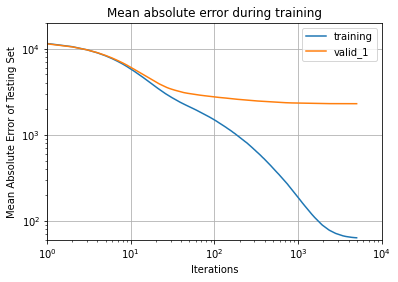

In [7]:
evals_result={}

params = {
    'task': 'train',
    'num_leaves': 200,
    'min_child_samples':10,
    'verbose':-1, 
    'n_estimators':5000,
    'metric': 'l1',
    'random_state':0,
}

train = lgb.Dataset(X_train, y_train)
test = lgb.Dataset(X_test, y_test)

#fit on training data
model = lgb.train(params, train, early_stopping_rounds=25, valid_sets= [train, test], evals_result=evals_result, verbose_eval=False)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('train score:', mae)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('test score:', mae)

lgb.plot_metric(evals_result, metric='l1')
plt.yscale('log')
plt.xscale('log')
plt.title('Mean absolute error during training')
plt.ylabel('Mean Absolute Error of Testing Set')
plt.ylim(6e1, 2e4)
plt.xlim(1, 10000)
plt.show()

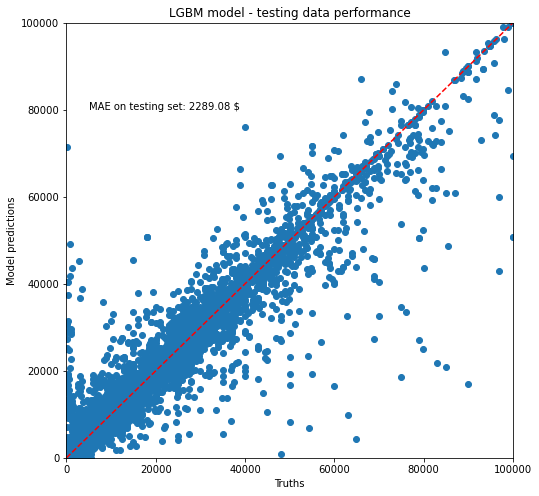

In [8]:
#https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

#fit on training data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
string_score = f'\nMAE on testing set: {mae:.2f} $'
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(5000, 80000, string_score)
plt.title('LGBM model - testing data performance')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 1e5])
_ = plt.ylim([0, 1e5])